In [9]:
import	yfinance	as	yf
import	numpy	as	np
import	pandas	as	pd
import	matplotlib.pyplot	as	plt
from sklearn.preprocessing	import	MinMaxScaler
from tensorflow.keras.models	import	Sequential
from tensorflow.keras.layers	import	LSTM,	Dense

In [10]:
 #	Download	historical	data	for	JPM
ticker	=	'BTC-USD'
data	=	yf.download(ticker,	start='2020-01-01',	end='2024-03-05')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [12]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


In [15]:
#	Scale	the	data
scaler	=	MinMaxScaler(feature_range=(0,	1))
scaled_data	=	scaler.fit_transform(data['Close'].values.reshape(-1,1))
#	Create	a	function	to	create	a	dataset	with	60	timesteps
def	create_dataset(dataset,	time_step=60):
  X,Y	=	[],	[]
  for	i	in	range(len(dataset)-time_step-1):
    a	=	dataset[i:(i+time_step),	0]
    X.append(a)
    Y.append(dataset[i	+	time_step,	0])
  return	np.array(X),	np.array(Y)
#	Create	the	dataset
time_step	=	60
X,y	=	create_dataset(scaled_data,	time_step)

In [16]:
 #	Split	the	data	into	train	and	test
train_size	=	int(len(X)	*	0.67)
test_size	=	len(X)	-	train_size
X_train,	X_test	=	X[0:train_size],	X[train_size:len(X)]
y_train,	y_test	=	y[0:train_size],	y[train_size:len(y)]

In [17]:
#	Reshape	input	to	be	[samples,	time	steps,	features]
X_train	=	X_train.reshape(X_train.shape[0],	X_train.shape[1],	1)
X_test	=	X_test.reshape(X_test.shape[0],	X_test.shape[1],	1)

In [18]:
#	Build	the	LSTM	model
model	=	Sequential()
model.add(LSTM(50,	return_sequences=True,	input_shape=(60,1)))
model.add(LSTM(50,	return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
#	Compile	the	model
model.compile(optimizer='adam',	loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [19]:
 #	Train	the	model
model.fit(X_train,	y_train,	batch_size=1,	epochs=1)

980/980 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0066


In [20]:
 #	Predicting	future	prices
predictions	=	model.predict(X_test)
predictions	=	scaler.inverse_transform(predictions)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [21]:
#	Calculate	the	root	mean	squared	error	(RMSE)
y_test_scaled	=	scaler.inverse_transform(y_test.reshape(-1,	1))
rmse	=	np.sqrt(np.mean((predictions	-	y_test_scaled)**2))
print(f"Root	Mean	Squared	Error:	{rmse}")

Root	Mean	Squared	Error:	2533.4926511186927


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.



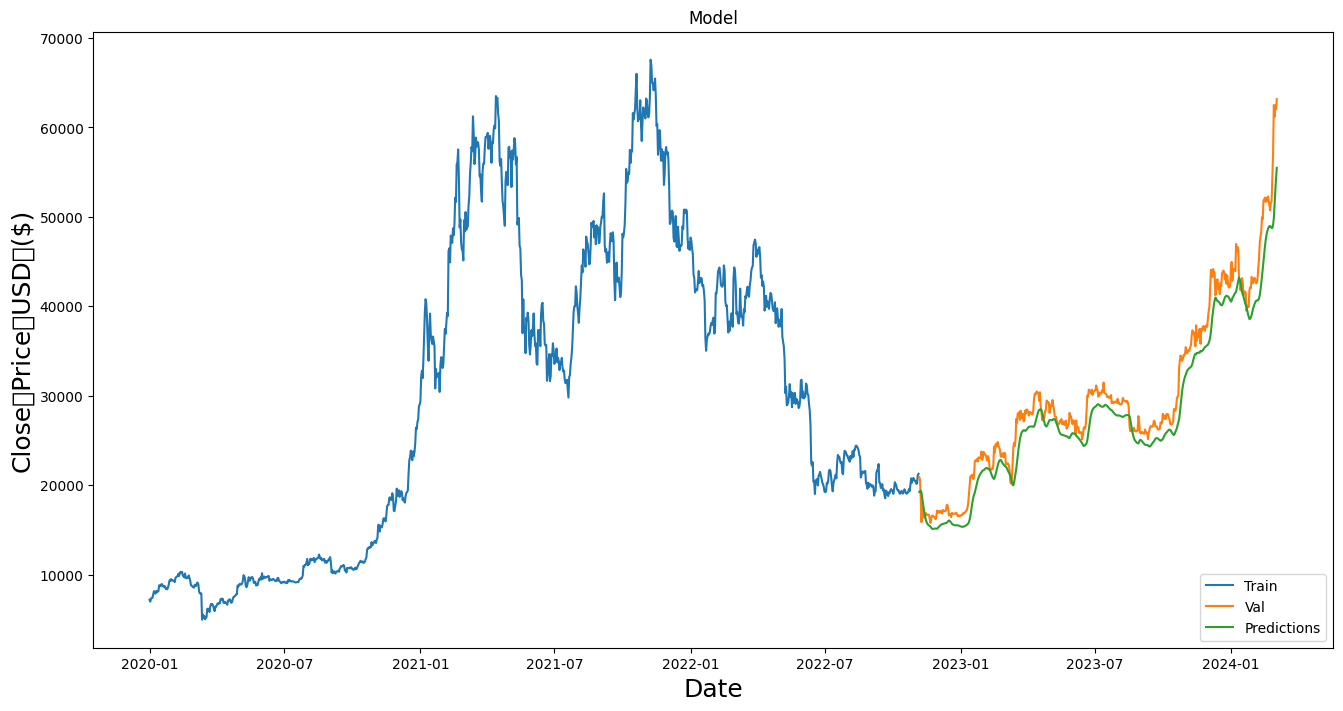

In [24]:
 #	Plot	the	data
train	=	data[:train_size+time_step]
valid	=	data[train_size+time_step:]
valid	=	valid.iloc[:len(predictions)]		#	Corrected	to	match	the	length	of	predictions
valid['Predictions']	=	predictions.flatten()
#	Visualize	the	data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',	fontsize=18)
plt.ylabel('Close	Price	USD	($)',	fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close',	'Predictions']])
plt.legend(['Train','Val','Predictions'],	loc='lower right')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.



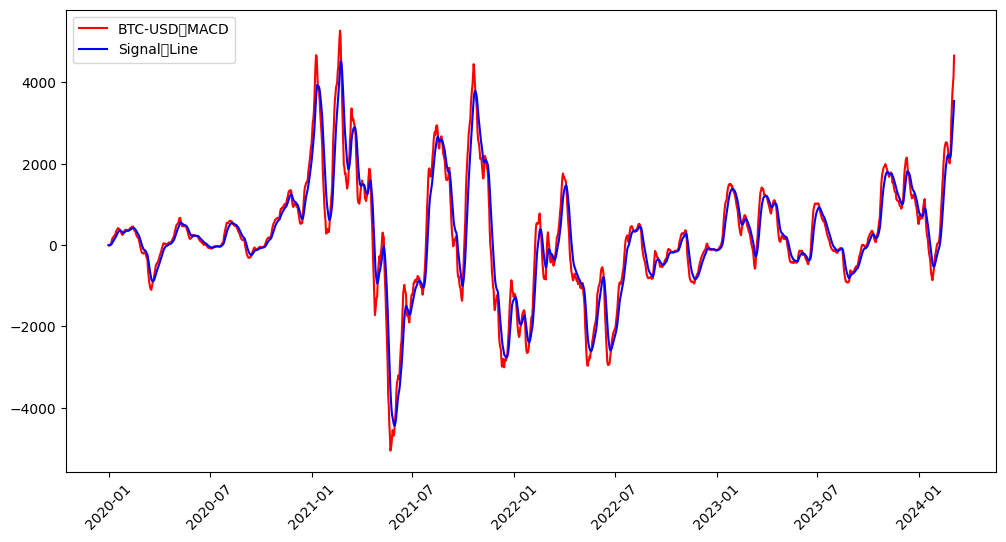

In [27]:
 #	Calculate	the	MACD	and	Signal	Line	indicators
ShortEMA	=	data.Close.ewm(span=12,	adjust=False).mean()
LongEMA	=	data.Close.ewm(span=26,	adjust=False).mean()
MACD	=	ShortEMA	-	LongEMA
signal	=	MACD.ewm(span=9,	adjust=False).mean()
#	Plot	the	chart
plt.figure(figsize=(12,6))
plt.plot(data.index,	MACD,	label='BTC-USD	MACD',	color	=	'red')
plt.plot(data.index,	signal,	label='Signal	Line',	color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')